## Lungs detection

Binary Object Detection / Regression notebook 

NOTE: I run this notebook with fast.ai v2.5 & Python 3.7.6. 

In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0 = id of the gpu
# To know which id have to be set on the previous line, on Windows 10 run "nvidia-smi" on CMD to check all the installed GPUs data, like
# the id, driver version and CUDA version 

# Check if your GPU driver and CUDA is enabled and is accessible by PyTorch
# TO USE CUDA SELECT A GPU ON THE EXECUTION ENVIRONMENT, NOT A TPU
import torch; print(torch.version.cuda) # the CUDA version must be printed
print(torch.cuda.is_available()) # True must be printed (if False press on the Restart button at the top of the notebook)
print(torch.cuda.current_device()) # the id of the GPU must be printed

11.3
True
0


In [43]:
from fastai.vision.all import *
from fastai.vision import *
from fastai.metrics import accuracy
from torch.nn import L1Loss
import cv2
from skimage.util import montage
from matplotlib.image import BboxImage
import numpy as np

## Getting and converting the data

In [44]:
# Get the path of the dataset of the trained model  

ds_path = '../../../Datasets/Dataset_train/subsetKaggleCOVID/original/train_val/'

In [45]:
# Get an image path from the dataset that will be used as a test to detect lungs
imgPath = ds_path + 'valid/' + '7149931905851290042143525080095735334_dr11hy.png'

In [46]:
# Get the annotations associated to an image 

def img2txt_name(imgPath): # imgPath is a string that contains the path of an image
    return imgPath.replace('.png', '.txt')

Path of the annotations file: ../../../Datasets/Dataset_train/subsetKaggleCOVID/original/train_val/valid/7149931905851290042143525080095735334_dr11hy.txt
Image size: (524, 524)


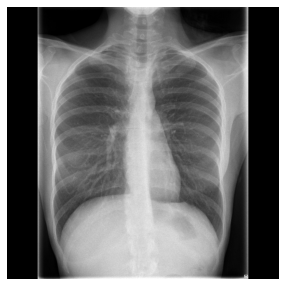

In [47]:
# Create the image associated to the filename stored previously
img = PILImage.create(imgPath)
img.show()
# Show the path of the annotations file associated to the image
print("Path of the annotations file:", img2txt_name(imgPath))
print("Image size:", img.size)

In [48]:
# Get annotations created with LabelImg of the bounding boxes corresponding to the lungs
# of an rx image

annotations = np.genfromtxt(img2txt_name(imgPath)); annotations
# annotations has 2 elements, the first one refers to the bbox of the lung left 
# and the second one refers to the bbox of the lung right
# Each element of annotations refers to a bbox data and has the following format:
# idClass, center_x, center_y, width and height) 
#   center_x : X coordinate of the center of the bbox /Image_width
#   center_y: Y coordinate of the center of the bbox / Image_height
#   width: width of the bbox / Image_width
#   heigth: height of the bbox / Image_height


array([[0.      , 0.314885, 0.504771, 0.293893, 0.742366],
       [1.      , 0.655534, 0.504771, 0.280534, 0.727099]])

In [49]:
# Generate the bounding boxes of an image with Path "imgPath"
#   "imgPath" is a Path and not a filename because the DataBlock object used next gets the paths 
#   of all the images of the dataset & stores them in a list named "get_image_files"
#   For each image of the dataset, it's path is passed as parameter in get_bboxes to generate the target bounding boxes 
def get_bboxes(imgPath):
    
    img = PILImage.create(str(imgPath))

    # Get the annotations of the bounding boxes of the lungs of the rx image with Path "f"
    fullAnnot = np.genfromtxt(img2txt_name(str(imgPath)))

    bboxes = np.zeros((2,4))

    for i in range(len(fullAnnot)):
        cx = int(fullAnnot[i][1]*img.size[0]) 
        cy = int(fullAnnot[i][2]*img.size[1])
        
        w = int(fullAnnot[i][3]*img.size[0])
        h = int(fullAnnot[i][4]*img.size[1])
        
        bbox = np.zeros(4)
        bbox[0] = float(cx-w/2.0) # minx 
        bbox[1] = float(cy-h/2.0) # miny
        bbox[2] = float(cx+w/2.0) # maxX
        bbox[3] = float(cy+h/2.0) # maxY

        bboxes[i] = bbox

    return bboxes

## Creating a dataset

In [50]:
# Cell
class NoLabelBBoxLabeler(Transform):
    """ Bounding box labeler with no label """
    def setups(self, x): noop
    def decode (self, x, **kwargs):
        self.bbox,self.lbls = None,None
        return self._call('decodes', x, **kwargs)

    def decodes(self, x:TensorBBox):
        self.bbox = x
        return self.bbox if self.lbls is None else LabeledBBox(self.bbox, self.lbls)

CustomBboxBlock = TransformBlock(type_tfms=TensorBBox.create, 
                             item_tfms=[PointScaler, NoLabelBBoxLabeler])               

class BBoxReshape(DisplayedTransform):
    "Normalize/denorm batch of `TensorImage`"
    parameters,order = L(),100
    def __init__(self): 
        noop

    def setups(self, dl:DataLoader):
        noop

    def encodes(self, x:TensorBBox): return torch.reshape(x,(x.shape[0],8)) # x.shape original is (64,2,4) and it gets converted to (64,8)
    def decodes(self, x:TensorBBox): return torch.reshape(x,(x.shape[0],2,4)) # x.shape original is (64,8) and it gets converted to (64,2,4)

In [51]:
# Documentation for this cell 
# -> (DataBlock creation) https://docs.fast.ai/tutorial.datablock.html#Bounding-boxes
# -> (Split train/val data) https://docs.fast.ai/data.transforms.html#FuncSplitter 

data = DataBlock(
    blocks=(ImageBlock, CustomBboxBlock), # ImageBlock means type of inputs are images; BBoxBlock & BBoxLblBlock = type of targets are BBoxes & their labels
    get_items=get_image_files,
    n_inp=1, # number of inputs; it's 1 because the only inputs are the rx images (ImageBlock)
    get_y= get_bboxes,
    splitter = FuncSplitter(lambda img: Path(img).parent.name == 'valid'), # split items by result of func (True for validation, False for training set). Images whose folder name is 'valid' are added to the validation set and the rest images are added to the training set.
    batch_tfms= [*aug_transforms(do_flip=False, size=(120,160)), Normalize.from_stats(*imagenet_stats), BBoxReshape] 
)

In [52]:
path_dl = Path(ds_path)
Path.BASE_PATH = path_dl
path_dl.ls().sorted()

(#4) [Path('lungs_detector_export.pkl'),Path('models'),Path('train'),Path('valid')]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


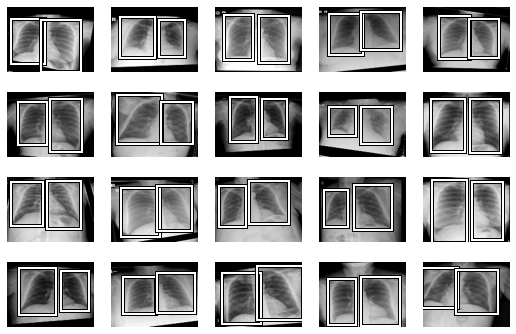

In [53]:
# Load the data and show a batch # NOTE: research to explain more properly what the 2 next lines do 

dls = data.dataloaders(path_dl, path=path_dl, bs = 64) # bs: how many samples per batch to load 
# If your GPU doesn't have enough memory and you can't run the whole notebook, 
# reduce the bs parameter value to, for example, 16 or 8
# and press the Restart button at the top of the notebook to empty the used memory

dls.show_batch(max_n=20, figsize=(9,6)) # NOTE: what do the values of figsize represent?
# NOTE: The batch shown contains validation and training images?

## Load learned model
from https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb


In [54]:
# Create the Lung Detector model from a pre-trained model  

class LungDetector(nn.Module):
    def __init__(self, arch=models.resnet18): # resnet18 has 18 lineal layers and it's the default arch if none arch is set as parameter
        super().__init__() 
        self.cnn = create_body(arch) # cut off the body of a typically pretrained arch
        self.head = create_head(num_features_model(self.cnn), 8)

    # NOTE: What does forward function mean?    
    def forward(self, im): # NOTE: what does im mean?
        x = self.cnn(im) # NOTE: why im is passed as parameter to cnn?
        x = self.head(x)
        # NOTE: Understand what the following line does?, what is x.sigmoid_()?
        return 2 * (x.sigmoid_() - 0.5) # (n_inp + bias) * n_out; bias = - 0.5, n_in = x.sigmoid_(), n_out = 2? (n_out I guess it should be 0 because now we don't have labels)

In [55]:
# Compare the output of the model (preds) with the ground truth (targs)
# If a high loss value is returned it mean the output is very different to the ground truth
# So, we want to get the minimum loss value possible

def loss_fn(preds, targs):
    return L1Loss()(preds, targs.squeeze()) # compute Mean Absolute Error # NOTE: check if squeeze is necessary? (squeeze turns i.e. 1x2x3 into 2x3)

In [56]:
# Create our own Learner object (we can also use Learners like cnn_learner() or unet_learner() ) 

# Check the documentation "https://fastai1.fast.ai/basic_train.html" to know about how a Learner works

# A Leaner is a trainer for model using data (dls) to minimize loss_func
# If path is provided, all the model files created will be saved in path/model_dir; if not, then they will be saved in data.path/model_dir.
learn = Learner(dls, LungDetector(arch=models.resnet50).cuda(), loss_func=loss_fn) # LungDetector.cuda() to work the model on GPU

# Load trained model
learn.load('lungs_detector')

## Inference

### Test set 

c:\Users\marcp\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.


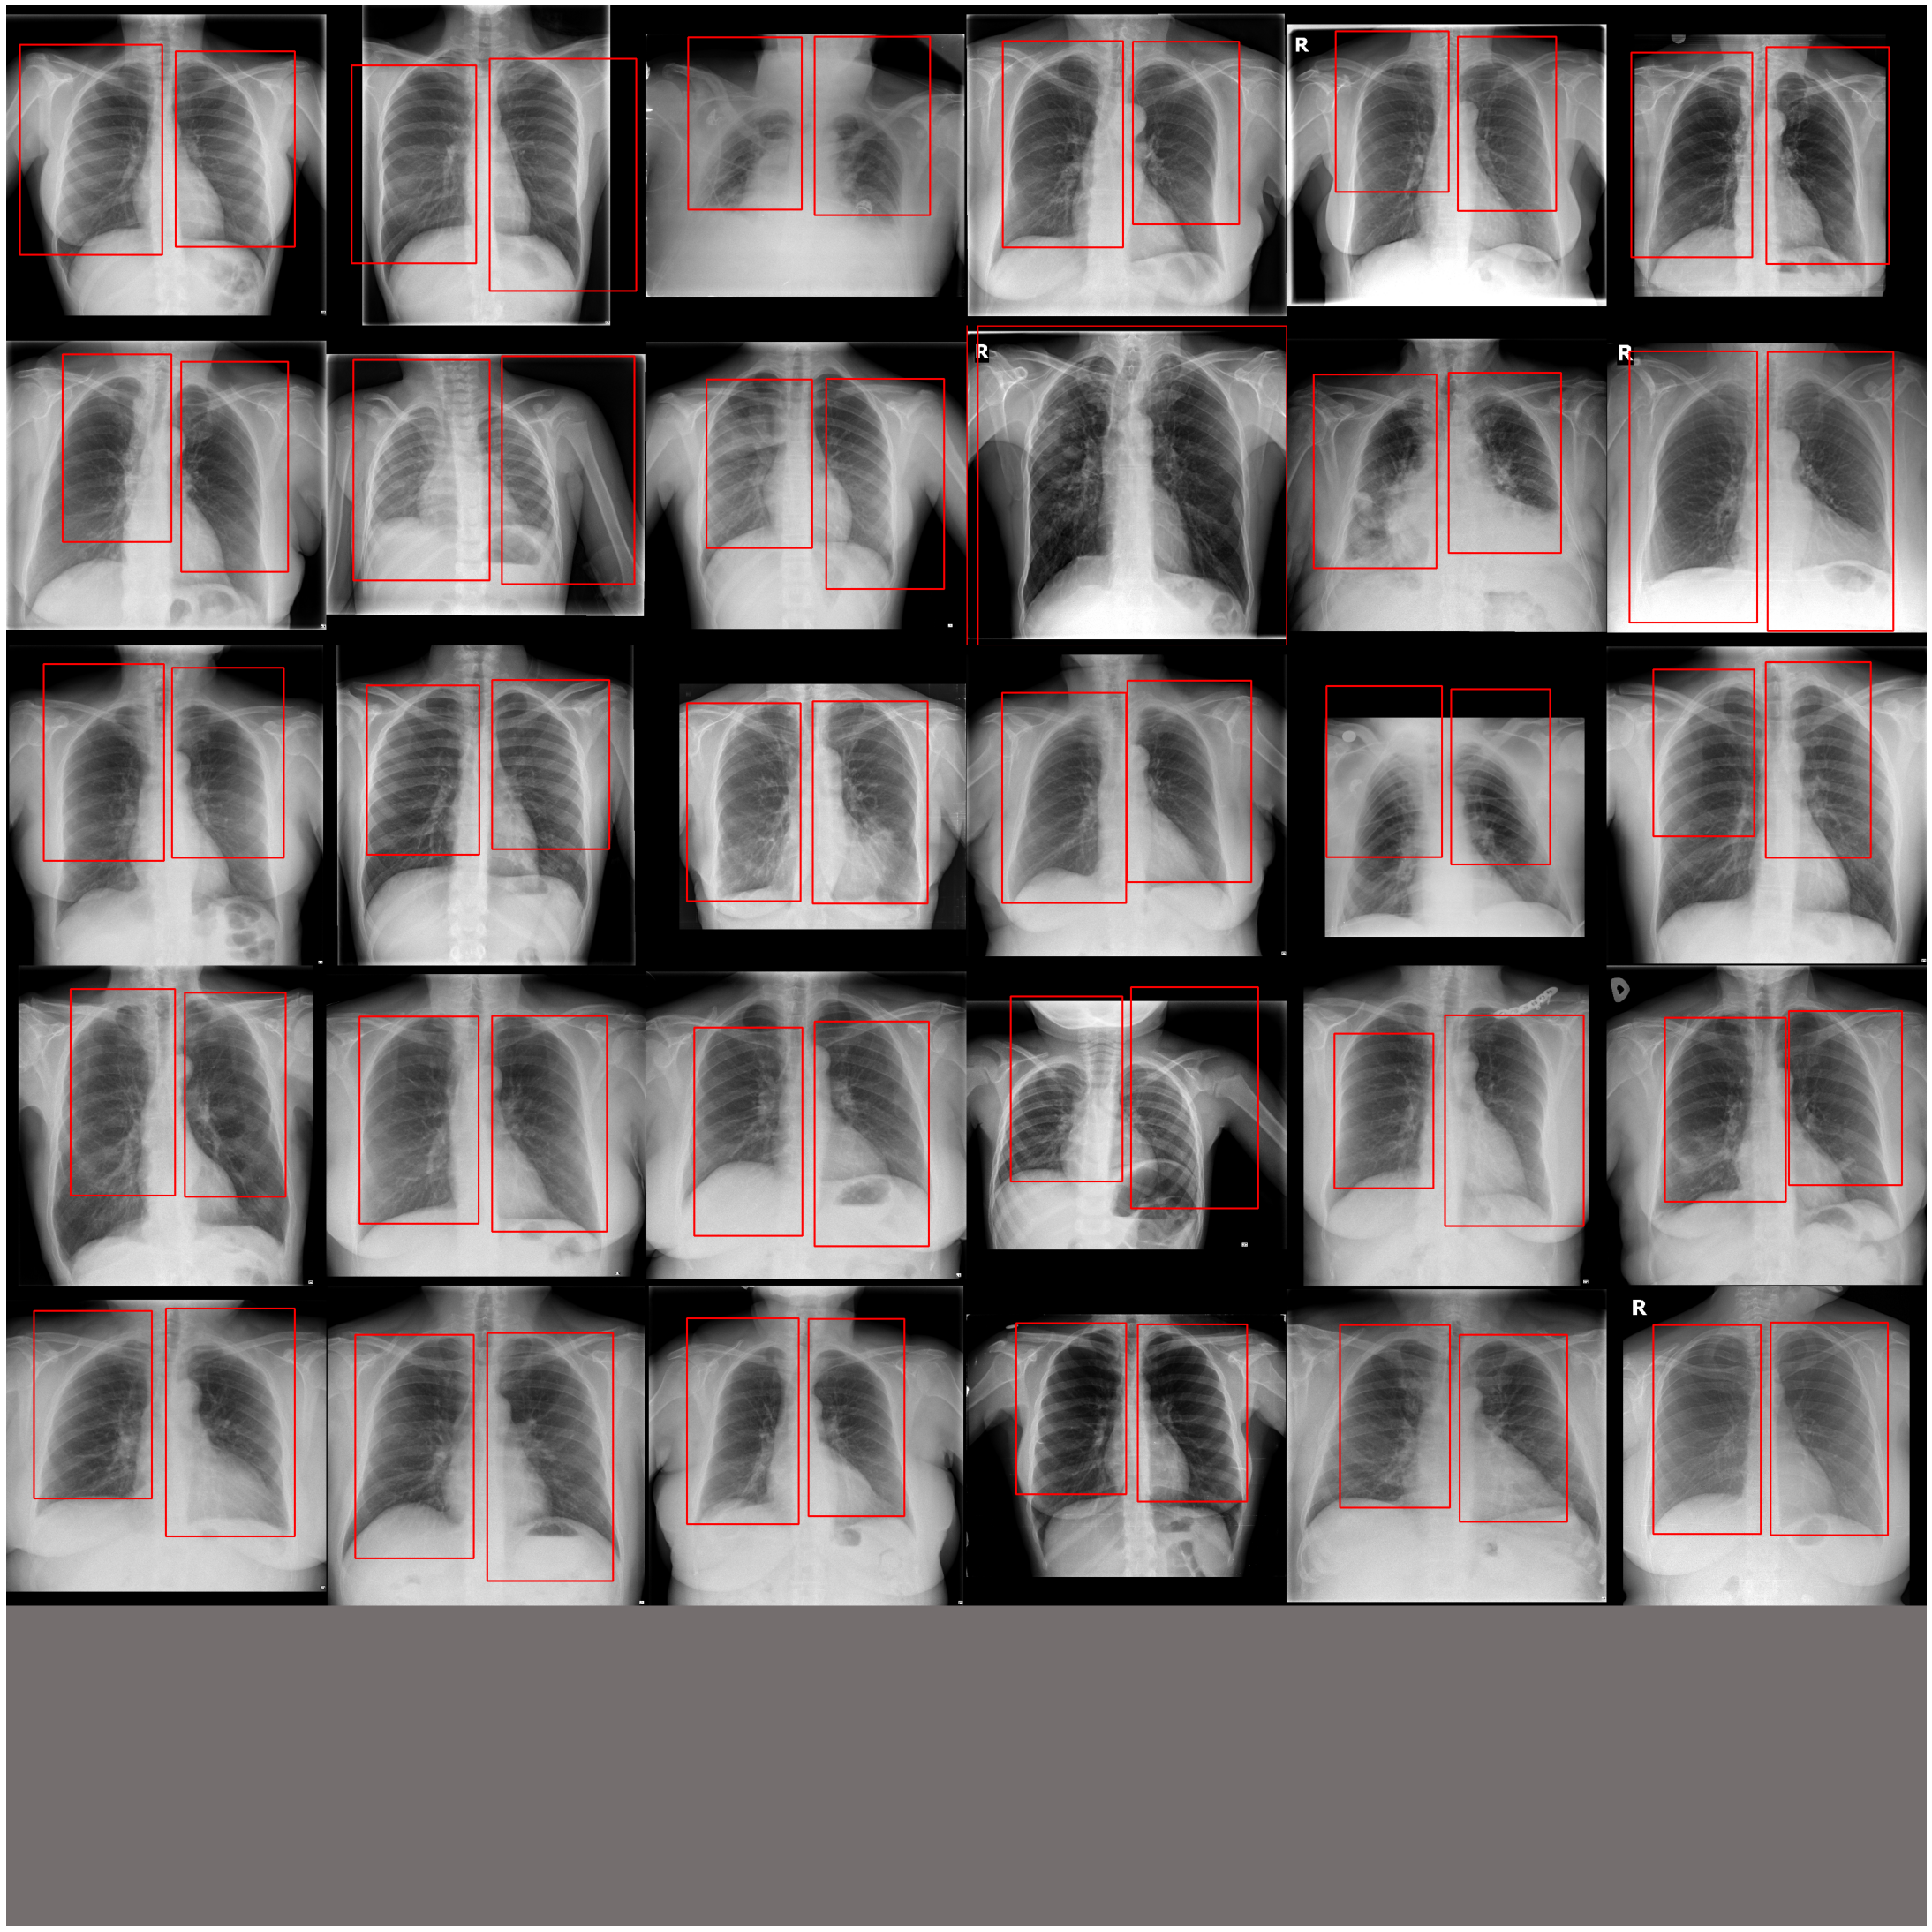

In [57]:
# Get test dataset
#testDsPath = "../../../Datasets/Datasets_test/pleuralEffusionGit/ds_torax/original/"
testDsPath = os.path.join('..', '..', '..', 'Datasets', 'Datasets_test', 'pleuralEffusionGit', 'ds_torax', 'original') 
test_files = get_image_files(testDsPath)
# Create a test dataloader from test_items using validation transforms of dls
test_dl = learn.dls.test_dl(test_files) # Documentation: https://docs.fast.ai/data.core.html#DataLoaders.test_dl

preds, _ = learn.get_preds(dl=test_dl) # _ refers to the target bounding boxes which don't exist for the test set (there aren't annotation .txt files )
# is necessary to include _ to avoid the error "TypeError: can only concatenate tuple (not "int") to tuple" on predicted_bboxes creation
# preds is a TensorBase that contains lists of bboxes coordinates of shape 1x8

predicted_bboxes = ((preds+1)/2).numpy() # ACCURATE PREDICTIONS RESULTS 
#predicted_bboxes = preds.numpy() # BAD PREDICTION RESULTS 
# (preds + 1) is used to make negative predictions turn into positive 
# NOTE: Why is ((preds + 1) divided by 2? are the predictions too big? (I GET THAT IT'S A NORMALIZATION OF PREDICTIONS)
# numpy() converts to a ndarray 


def draw_bboxes(img, bboxes, target=None, color=(255, 0, 0), thickness=2):
# bboxes & target shape are (8,) the first 4 values refer to the coordinates of the left lung an ther last 4 ones refer 
# to the coordinates of the right lung

    sx,sy,ch = img.shape

    i = 0
    while(i < 8):
        bboxes[i] = bboxes[i]*sx # NOTE: why multiply by sy if bbox[0] refers to minx
        bboxes[i+1] = bboxes[i+1]*sy # NOTE: why multiply by sx if bbox[1] refers to minx
        bboxes[i+2] = bboxes[i+2]*sx
        bboxes[i+3] = bboxes[i+3]*sy
        x_min, y_min, x_max, y_max = map(int, bboxes[i:i+4])
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
        if target is not None:
            target[i] = target[i]*sx
            target[i+1] = target[i+1]*sy
            target[i+2] = target[i+2]*sx
            target[i+3] = target[i+3]*sy
            x_min, y_min, x_max, y_max = map(int, target[i:i+4])
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
        i = i+4
    return img

def cv_read(path): 
    path = str(path)
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


ims = np.stack([draw_bboxes(cv_read(dls.valid_ds.items[i]), predicted_bboxes[i]) for i in range(30)]) # show only the first 30 images of the test dataset

# Show test images with their predictions (PREDICTIONS ARE IN RED)
plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [58]:
# Get the loss and the accuracy/IoU of the test set
# CELL NOT WORKING 

# learn.validate(dl=test_dl)

# learn.validate should return a list with 2 values
# 1st the test loss and 2nd the metrics result (in the case of this model the metrics are IoU, Intersection over Union)

# NOTE: I guess it returns [None] because the test set doesn't c0ntains annotations files (.txt)
# so, fastai doesn't know which are targets related to the predicted bboxes and 
# it can't calculate the test loss and the metrics that is the IoU between predictions and targets


#### Save predicted bboxes as images

In [61]:
# For each set of the original test dataset,
# create images of the predicted bboxes of the left and right lung combined
# & save them on the processed test dataset 

testImsProcessedPath = "../../../Datasets/Datasets_test/pleuralEffusionGit/ds_torax/processed"

def resize(img, height, width):
    """ Resize an image to the size (width, height)"""
    imgResized = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)
    return imgResized

def save(img, imgPathDesti):
    """Save the image of the bboxes combined to 'imgPathDesti'"""
    cv2.imwrite(imgPathDesti, img)

# 1st. Create the folders 'train/'valid'/test in the processed dataset 
# and for each one create the subfolders 'normal' / 'effusion' 
train_val_dir = os.path.join(testImsProcessedPath, "train_val") 
test_dir = os.path.join(testImsProcessedPath, "test") 

for set in ['train', 'valid', 'test']:
    if set == 'test':
        output_dir_set = test_dir
    else:
        output_dir_set = os.path.join(train_val_dir, set) 

    # Get the paths of 'normal' and 'effusion' subfolders 
    normal_dir = os.path.join(output_dir_set, 'normal')
    effusion_dir = os.path.join(output_dir_set, 'effusion')

    # Delete if possible the folders 'normal' and 'effusion' from previous executions of this notebook
    shutil.rmtree(normal_dir, ignore_errors=True) # making ignore_errors = True will not raise a FileNotFoundError in case directory doesn't exist
    shutil.rmtree(effusion_dir, ignore_errors=True)

    # Create folders named 'normal' and 'effusion' and their parent folders named 'train'/'valid'/'test'
    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(effusion_dir, exist_ok=True)


# 2nd. Fill the processed dataset with images of the predicted bounding boxes combined for each X-ray case

width = 150
height = 300

print("Started storing the images of the predicted bboxes")

# Iterate all test images named predicted_bboxes
for i in range(len(predicted_bboxes)):
    # Get the current original test image
    originalImgPath = test_files[i]
    fullOriginalImg = PILImage.create(originalImgPath) # load the image in grayscale (but the image is already in grayscale)
    fullOriginalImg = np.array(fullOriginalImg)

    # Get the images of the predicted bounding boxes
    # bboxLeft & bboxRight contain the bbox coordinates ordered as: minX, minY, maxX, maxY  
    bboxLeft = predicted_bboxes[i][0:4]
    imgBboxLeft = fullOriginalImg[int(bboxLeft[1]):int(bboxLeft[3]), int(bboxLeft[0]):int(bboxLeft[2])]
    # fullOriginalImg[rowStart: rowEnd, colStart: colEnd] where rowStart:rowEnd = minY:maxY and colStart:colEnd = minX:maxX 
    bboxRight = predicted_bboxes[i][4:8]
    imgBboxRight = fullOriginalImg[int(bboxRight[1]):int(bboxRight[3]), int(bboxRight[0]):int(bboxRight[2])]

    # Resize the image of each bounding box to the size (width=150, height=300)
    imgBboxLeftResized = resize(imgBboxLeft, height, width)
    imgBboxRightResized = resize(imgBboxRight, height, width)
    imgsBboxesResized =[imgBboxLeftResized, imgBboxRightResized]
    
    # Create an image that combines the image of the bbox left with the image of the bbox right
    imgBboxesCombined = cv2.hconcat(imgsBboxesResized)
    processedImgLungsPath = str(originalImgPath).replace("original", "processed")
    save(imgBboxesCombined, processedImgLungsPath)

print("Done saving the predicted bboxes")

Started storing the images of the predicted bboxes


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
